# Classification supervisée
On a utilisé  4 approches  présentées ci-dessous :

1. Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée

2. Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images

3. Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation

4. Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


# Préparation du dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
data = pd.read_csv('Data/data.csv')

In [3]:
data['Cluster_catego'].unique()

array([0., 1., 6., 2., 3., 4., 5.])

In [4]:
max(data['Cluster_catego'])

6.0

In [5]:
data['main_category'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [6]:
data

,Unnamed: 0,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,stemmer_prodct_name,tokenize_stem_descr,tokenize_stem_prodname,tokenize_stem_prodct_name,group,word_length,bigram,bigram_trigram,Cluster,label_kmeans
0,0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,featur eleg polyest multicolor abstract eyelet...,"['featur', 'eleg', 'polyest', 'multicolor', 'a...","['eleg', 'polyest', 'multicolor', 'abstract', ...","['featur', 'eleg', 'polyest', 'multicolor', 'a...",1,148,"['feature', 'elegance', 'polyester', 'multicol...","['feature', 'elegance', 'polyester', 'multicol...",6,7
1,1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,specif sathiya cotton bath towel bath towel ye...,"['specif', 'sathiya', 'cotton', 'bath', 'towel...","['sathiya', 'cotton', 'bath', 'towel']","['specif', 'sathiya', 'cotton', 'bath', 'towel...",1,59,"['specification', 'sathiyas', 'cotton', 'bath_...","['specification', 'sathiyas', 'cotton', 'bath_...",3,7
2,2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,featur eurospa cotton terri face towel size sm...,"['featur', 'eurospa', 'cotton', 'terri', 'face...","['eurospa', 'cotton', 'terri', 'face', 'towel']","['featur', 'eurospa', 'cotton', 'terri', 'face...",1,134,"['feature', 'eurospa', 'cotton', 'terry', 'fac...","['feature', 'eurospa', 'cotton', 'terry', 'fac...",5,7
3,3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,featur santosh royal fashion cotton print king...,"['featur', 'santosh', 'royal', 'fashion', 'cot...","['santosh', 'royal', 'fashion', 'cotton', 'pri...","['featur', 'santosh', 'royal', 'fashion', 'cot...",1,111,"['feature', 'santosh_royal', 'fashion', 'cotto...","['feature', 'santosh_royal', 'fashion', 'cotto...",3,0
4,4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,featur jaipur print cotton floral king size do...,"['featur', 'jaipur', 'print', 'cotton', 'flora...","['jaipur', 'print', 'cotton', 'floral', 'king'...","['featur', 'jaipur', 'print', 'cotton', 'flora...",1,142,"['feature', 'jaipur', 'print', 'cotton', 'flor...","['feature', 'jaipur', 'print', 'cotton', 'flor...",3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,...,oren empow extra larg self adhes sticker pack ...,"['oren', 'empow', 'extra', 'larg', 'self', 'ad...","['oren', 'empow', 'extra', 'larg', 'self', 'ad...","['oren', 'empow', 'extra', 'larg', 'self', 'ad...",1,210,"['oren', 'empower', 'extra_large', 'self_adhes...","['oren', 'empower', 'extra_large', 'self_adhes...",2,5
1046,1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,...,wallmantra larg vinyl sticker sticker pack pri...,"['wallmantra', 'larg', 'vinyl', 'sticke

In [7]:
from sklearn import preprocessing

In [8]:
data_train, data_test = train_test_split(data, test_size = 0.3, random_state=41)

In [9]:
data_train['image'] = data_train['image'].apply(lambda x: 'Flipkart/Images/'+str(x))
data_test['image'] = data_test['image'].apply(lambda x: 'Flipkart/Images/'+str(x))
data['image']=data['image'].apply(lambda x: 'Flipkart/Images/'+str(x))


In [10]:
list_labels=data['main_category'].unique()

In [11]:
#le = preprocessing.LabelEncoder()
#le.fit(data["main_category"])
#data["label"] = le.transform(data["main_category"])
#data_test["label"] = le.transform(data_test["main_category"])
#data_train["label"] = le.transform(data_train["main_category"])


In [12]:
data_train

,Unnamed: 0,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,stemmer_prodct_name,tokenize_stem_descr,tokenize_stem_prodname,tokenize_stem_prodct_name,group,word_length,bigram,bigram_trigram,Cluster,label_kmeans
902,902,4b59516432fbc3d61e8e58d547fde431,2016-06-07 02:43:22 +0000,http://www.flipkart.com/prisha-india-craft-m-j...,Prisha India Craft m_jug015-1-prishaindia Wate...,JUGEJE2HFCQGZGDE,2470.0,1899.0,Flipkart/Images/4b59516432fbc3d61e8e58d547fde4...,False,...,featur prisha india craft m_jug prishaindia wa...,"['featur', 'prisha', 'india', 'craft', 'm_jug'...","['prisha', 'india', 'craft', 'm_jug', 'prishai...","['featur', 'prisha', 'india', 'craft', 'm_jug'...",1,167,"['feature', 'prisha', 'india', 'craft', 'm_jug...","['feature', 'prisha', 'india', 'craft', 'm_jug...",2,4
232,232,4642d967bc34a36454b281de632f6c11,2015-12-01 12:40:44 +0000,http://www.flipkart.com/sovam-international-ra...,Sovam International Radha Krishna God Showpiec...,SHIE8QE6YQDMWHBZ,3659.0,1899.0,Flipkart/Images/4642d967bc34a36454b281de632f6c...,False,...,sovam intern radha krishna showpiec brass whit...,"['sovam', 'intern', 'radha', 'krishna', 'showp...","['sovam', 'intern', 'radha', 'krishna', 'showp...","['sovam', 'intern', 'radha', 'krishna', 'showp...",1,37,"['sovam_international', 'radha_krishna', 'show...","['sovam_international', 'radha_krishna', 'show...",1,7
745,745,daf06eb2b9613900299539558e287701,2015-12-12 11:46:53 +0000,http://www.flipkart.com/nutcase-sticker-wrap-d...,Nutcase Sticker Wrap Design - Mint & Grey Chev...,BOTEANCHRVE7K3CS,799.0,399.0,Flipkart/Images/daf06eb2b9613900299539558e2877...,False,...,nutcas sticker wrap design mint grey chevron b...,"['nutcas', 'sticker', 'wrap', 'design', 'mint'...","['nutcas', 'sticker', 'wrap', 'design', 'mint'...","['nutcas', 'sticker', 'wrap', 'design', 'mint'...",1,65,"['nutcase', 'sticker', 'wrap', 'design', 'mint...","['nutcase', 'sticker', 'wrap', 'design', 'mint...",5,7
1034,1034,7815fb39feb773db944c9f03bbdcbf64,2016-03-03 06:06:42 +0000,http://www.flipkart.com/print-shapes-peacock-f...,PRINT SHAPES Peacock Feather Laptop Skin with ...,LACEGF4N8UFADEGZ,999.0,329.0,Flipkart/Images/7815fb39feb773db944c9f03bbdcbf...,False,...,featur print shape peacock feather laptop skin...,"['featur', 'print', 'shape', 'peacock', 'feath...","['print', 'shape', 'peacock', 'feather', 'lapt...","['featur', 'print', 'shape', 'peacock', 'feath...",1,102,"['feature', 'print', 'shape', 'peacock_feather...","['feature', 'print', 'shape', 'peacock_feather...",1,7
582,582,a7bd63ef1d3b345d7f9a162865bb7c0d,2016-01-07 05:50:25 +0000,http://www.flipkart.com/flippd-fd040149-casual...,Flippd FD040149 Casual Analog Watch - For Wom...,WATE8E8PGC6SARZG,999.0,999.0,Flipkart/Images/a7bd63ef1d3b345d7f9a162865bb7c...,True,...,flippd casual analog watch women girl flippd c...,"['flippd', 'casual', 'analog', 'watch', 'women...","['flippd', 'casual', 'analog', 'watch', 'women...","['flippd', 'casual', 'analog', 'watch', 'women...",1,31,"['flippd', 'casual', 'analog', 'watch', 'woman...","['flippd', 'casual', 'analog', 'watch', 'woman...",4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,282,a8ea6fc2b3cd95f46bced80853ce8e0e,2016-04-24 18:34:50 +0000,http://www.flipkart.com/cherry-crumble-califor...,cherry crumble california Baby Boy's Dungaree,DRPEHQY8Z5UZFP7V,2499.0,2499.0,Flipkart/Images/a8ea6fc2b3cd95f46bced80853ce8e...,False,...,featur cherri crumbl california babi boy dunga...,"['featur', 'cherri', 'crumbl', 'california', '...","['cherri', 'crumbl', 'california', 'babi', 'bo...","['featur', 'cherri', 'crumbl', 'california', '...",1,39,"['feature', 'cherry_crumble', 'california', 'b...","['feature', 'cherry_crumble', 'california', 'b...",0,7
407,407,dbf7c443a45d684944b5d9928eef051f,2015-12-01 06:13:00 +0000,http://www.flipkart.com/trendnet-n300-wireless...,TRENDnet N300 Wireless Home Router,RTRDQZMJYG3JQ7PM,2850.0,122

# Etape 1 : étude de faisabilité

In [13]:
from sklearn import cluster, metrics

## Création du modèle pré-entraîné

In [14]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Création des features des images

In [15]:
images_features = []
i=0 
for image_file in data["image"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


/Users/ngenzi/anaconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA

In [16]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [17]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             4.91 secondes


/var/folders/bv/sjkhlnjd4pb40pjnc0ykwp340000gn/T/ipykernel_959/2948496633.py:5: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


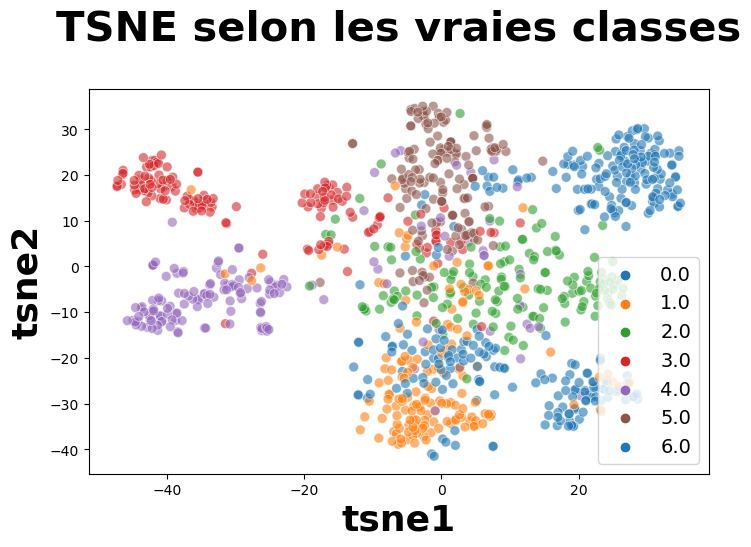

In [18]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["Cluster_catego"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=6), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [19]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, init='k-means++', random_state=9, n_init=30)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=30, random_state=9)

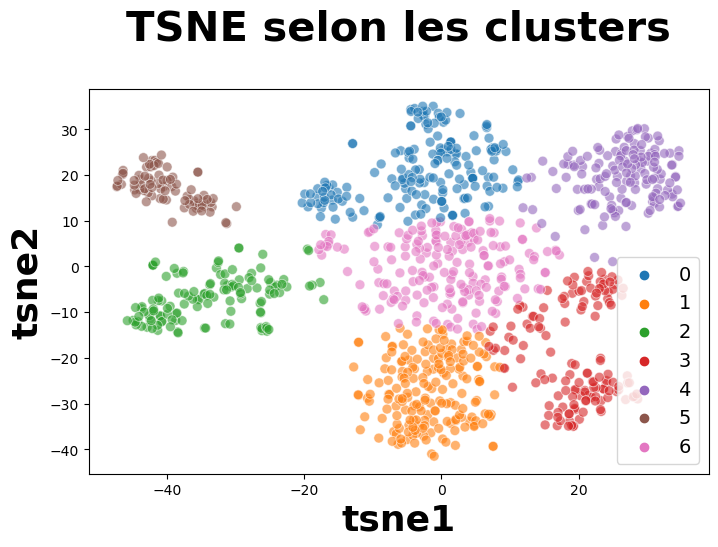

ARI :  0.45469902568611437


In [20]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["Cluster_catego"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes

In [21]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  0  72   0  72   0   0   6]
 [  1 109   3   8   1   1  27]
 [  5   2   1  54   8   0  80]
 [ 37   0   5   0   0  78  30]
 [  9   4 117   7   0   1  12]
 [113   1   1   0   1   0  34]
 [ 13   0   0   0 135   0   2]]


In [22]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [23]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [5 1 4 0 6 3 2]
[[ 72  72   6   0   0   0   0]
 [  8 109  27   1   3   1   1]
 [ 54   2  80   0   1   5   8]
 [  0   0  30  78   5  37   0]
 [  7   4  12   1 117   9   0]
 [  0   1  34   0   1 113   1]
 [  0   0   2   0   0  13 135]]

              precision    recall  f1-score   support

         0.0       0.51      0.48      0.49       150
         1.0       0.58      0.73      0.64       150
         2.0       0.42      0.53      0.47       150
         3.0       0.97      0.52      0.68       150
         4.0       0.92      0.78      0.84       150
         5.0       0.63      0.75      0.69       150
         6.0       0.93      0.90      0.92       150

    accuracy                           0.67      1050
   macro avg       0.71      0.67      0.68      1050
weighted avg       0.71      0.67      0.68      1050



<Axes: >

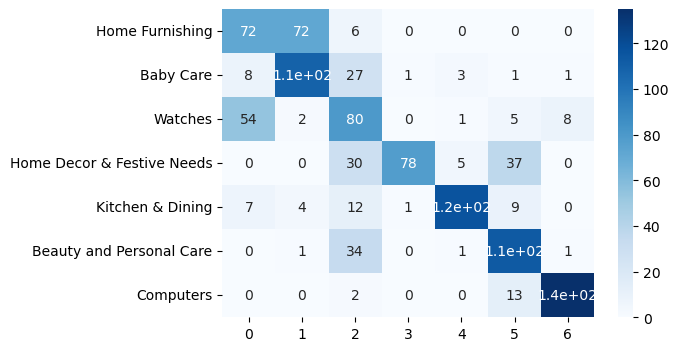

In [24]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

## Approche préparation initiale des images

In [25]:
from tensorflow.keras.optimizers import SGD
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(4056, activation='relu')(x) 
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    #model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
    model.compile(loss="categorical_crossentropy", optimizer=SGD(learning_rate=0.0001), metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [26]:
#model.compile(loss='sparse_categorical_crossentropy', 
 #            optimizer=SGD(learning_rate=0.01), 
  #           metrics=['accuracy'])

In [27]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image'])) :
        img = (load_img(
            data['image'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(data)
print(images_np.shape)


/Users/ngenzi/anaconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)


In [28]:
data_test=data_test.reset_index()
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(315, 224, 224, 3)


In [29]:
X = images_np
y = to_categorical(data['Cluster_catego'])

X_test = images_np_test
y_test = to_categorical(data_test['Cluster_catego'])

y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=4)
X_train.shape

(840, 224, 224, 3)

In [31]:
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [32]:
batch_size =64
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history1 = model1.fit(X_train, y_train, epochs=140, batch_size=batch_size, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/140
14/14 [==============================] - ETA: 0s - loss: 4.9778 - accuracy: 0.1750
Epoch 1: saving model to ./model1_best_weights.h5
14/14 [==============================] - 99s 7s/step - loss: 4.9778 - accuracy: 0.1750 - val_loss: 2.8873 - val_accuracy: 0.2190
Epoch 2/140


/Users/ngenzi/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - ETA: 0s - loss: 4.2578 - accuracy: 0.1881
Epoch 2: saving model to ./model1_best_weights.h5
14/14 [==============================] - 99s 7s/step - loss: 4.2578 - accuracy: 0.1881 - val_loss: 2.1591 - val_accuracy: 0.2952
Epoch 3/140
14/14 [==============================] - ETA: 0s - loss: 3.7039 - accuracy: 0.2417
Epoch 3: saving model to ./model1_best_weights.h5
14/14 [==============================] - 97s 7s/step - loss: 3.7039 - accuracy: 0.2417 - val_loss: 1.8306 - val_accuracy: 0.3714
Epoch 4/140
14/14 [==============================] - ETA: 0s - loss: 3.3833 - accuracy: 0.2857
Epoch 4: saving model to ./model1_best_weights.h5
14/14 [==============================] - 93s 7s/step - loss: 3.3833 - accuracy: 0.2857 - val_loss: 1.6125 - val_accuracy: 0.4333
Epoch 5/140
14/14 [==============================] - ETA: 0s - loss: 2.9720 - accuracy: 0.3488
Epoch 5: saving model to ./model1_best_weights.h5
14/14 [==============================] - 92s 

Epoch 31: early stopping


In [33]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

27/27 [==============================] - 74s 3s/step - loss: 0.5602 - accuracy: 0.8190
Training Accuracy: 0.8190

7/7 [==============================] - 18s 3s/step - loss: 0.7272 - accuracy: 0.7762
Validation Accuracy:  0.7762


In [34]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7762
Test Accuracy       :  0.8508


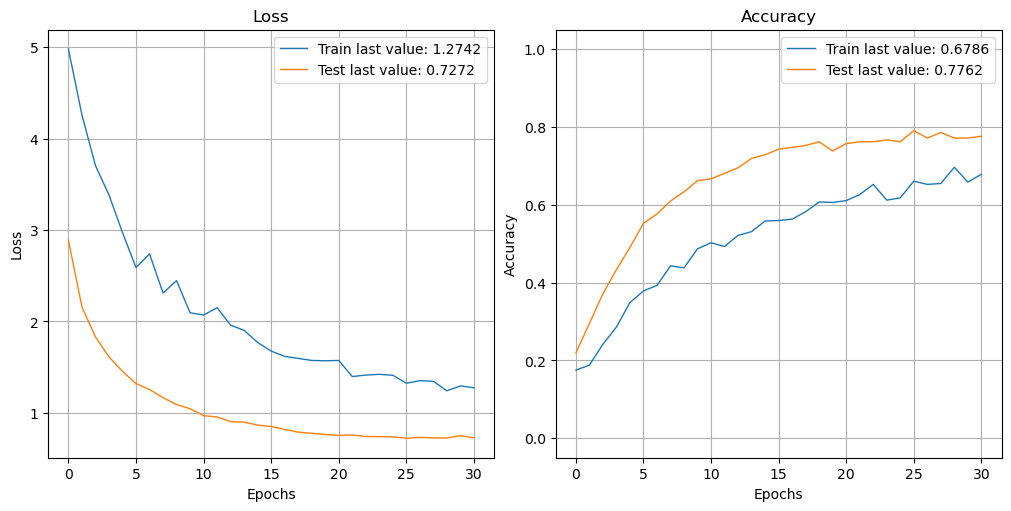

In [35]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [36]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 19s 3s/step
[4 2 4 4 6 1 4 3 0 0 0 5 0 5 6 5 0 5 6 4 3 2 6 0 6 5 3 2 2 6 1 2 5 6 5 5 2
 2 3 2 4 3 5 3 4 0 1 1 0 3 5 4 6 2 1 1 5 6 2 6 2 6 5 6 4 1 2 2 6 1 3 3 5 5
 0 1 2 3 0 3 1 6 1 4 4 0 0 4 1 0 6 3 4 0 6 0 4 1 4 0 3 3 3 2 5 0 5 5 1 4 6
 4 4 0 2 5 0 2 4 1 1 2 1 3 1 6 4 0 3 5 2 1 4 3 5 3 2 6 0 1 6 1 3 2 4 0 6 1
 6 3 6 3 2 1 0 6 3 1 2 1 0 0 1 3 5 3 3 6 4 4 1 2 5 0 3 3 5 5 2 2 3 1 4 5 6
 4 5 2 2 2 6 0 5 5 0 6 3 5 5 2 4 1 0 4 4 1 6 4 6 0]

[4 2 4 4 6 1 4 6 0 0 0 5 0 3 6 5 4 5 6 4 3 2 6 1 5 5 3 2 2 6 0 2 5 6 4 5 2
 2 3 2 4 3 5 3 4 2 1 1 0 3 5 4 6 2 3 1 5 6 2 6 2 6 0 6 4 1 2 2 6 6 3 5 5 5
 0 1 2 3 0 0 1 6 1 4 4 2 0 5 5 0 6 3 0 0 6 0 1 2 4 0 3 5 3 2 4 0 5 4 0 3 6
 4 4 0 2 5 0 2 4 0 0 2 0 2 1 6 5 0 3 2 2 1 4 3 2 5 2 6 0 1 6 1 3 2 4 0 6 2
 6 3 6 5 2 0 0 6 3 4 2 0 0 0 0 3 4 4 3 6 4 4 3 4 5 0 3 3 5 5 0 2 3 1 4 5 6
 4 3 2 2 3 6 0 5 5 0 6 3 5 5 2 4 3 0 4 4 1 6 4 6 2]


In [37]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[25  1  3  0  1  0  0]
 [ 8 14  2  3  1  1  1]
 [ 1  0 27  1  1  0  0]
 [ 1  0  1 22  1  4  1]
 [ 1  1  0  1 25  2  0]
 [ 1  0  2  2  4 21  0]
 [ 0  0  0  0  0  1 29]]


In [38]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[25  1  3  0  1  0  0]
 [ 8 14  2  3  1  1  1]
 [ 1  0 27  1  1  0  0]
 [ 1  0  1 22  1  4  1]
 [ 1  1  0  1 25  2  0]
 [ 1  0  2  2  4 21  0]
 [ 0  0  0  0  0  1 29]]

              precision    recall  f1-score   support

           0       0.68      0.83      0.75        30
           1       0.88      0.47      0.61        30
           2       0.77      0.90      0.83        30
           3       0.76      0.73      0.75        30
           4       0.76      0.83      0.79        30
           5       0.72      0.70      0.71        30
           6       0.94      0.97      0.95        30

    accuracy                           0.78       210
   macro avg       0.79      0.78      0.77       210
weighted avg       0.79      0.78      0.77       210



<Axes: >

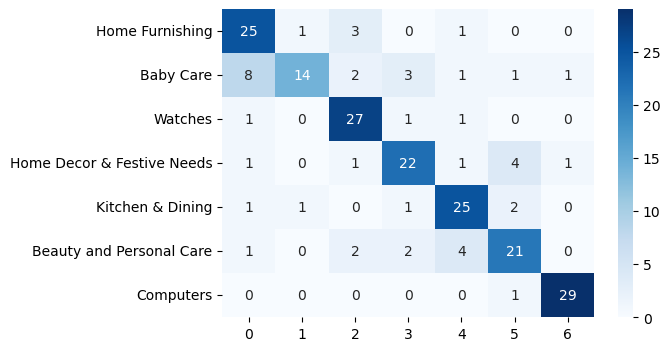

In [39]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [77]:
from sklearn.metrics import confusion_matrix

In [79]:
confusion_matrix(y_val_num, y_val_pred).ravel()

array([25,  1,  3,  0,  1,  0,  0,  8, 14,  2,  3,  1,  1,  1,  1,  0, 27,
        1,  1,  0,  0,  1,  0,  1, 22,  1,  4,  1,  1,  1,  0,  1, 25,  2,
        0,  1,  0,  2,  2,  4, 21,  0,  0,  0,  0,  0,  0,  1, 29])

### Contourner l’overfitting

## Data Augmentation

**Qu’est-ce que c’est ?**

L’overfitting est dû au fait que l’on dispose de trop peu de données.

Le modèle a trop peu de cas d’usage différent ce qui rend difficile son entraînement. Par conséquent il ne peut pas développer des règles de décisions pouvant être généralisé à de nouvelles données.

Il nous faut plus de données… et donc dans notre cas, plus de photos. Ce n’est pas une tâche facile a faire.

Heureusement, il existe une technique pour augmenter notre nombre de données. On peut créer des images artificielles grâce à la Data Augmentation (littéralement : l’augmentation des données).

L’idée derrière la Data Augmentation est de reproduire les données préexistantes en leur appliquant une transformation aléatoire. Par exemple, appliquer un effet mirroir sur une image.

Lors de l’entraînement, notre modèle apprendra sur beaucoup plus de données tout en ne rencontrant jamais deux fois la même image.

Le modèle est donc exposé à davantage de données. Cela lui permet de mieux généraliser.

Vérifions cela maintenant ! 😉

Comment l’utiliser ?

On peut faire de la Data Augmentation en utilisant la fonction **ImageDataGenerator** déjà utilisé plus haut et en modifiant certains paramètres :

rotation_range pour faire pivoter une image de façon aléatoire sur une plage entre 0 et la valeur choisis (maximum 180 degré)
width_shift et height_shift sont des plages (en fraction de la largeur ou de la hauteur totale) à l’intérieur desquelles on peut redimensionner aléatoirement des images verticalement ou horizontalement.
shear_range est une plage permettant de rogner(découper) de manière aléatoire l’image
zoom_range permet de zoomer de manière aléatoire à l’intérieur des images
horizontal_flip retourne horizontalement des images de manière aléatoire (certaines seront retourner d’autres non)
fill_mode est la stratégie utilisée pour remplir les pixels nouvellement créés, qui peuvent apparaître après un pivotage, un rognage, etc
On utilise ces quelques paramètres mais encore une fois, il en existe d’autres sur la documentation Keras !

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [42]:


def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image', y_col='main_category',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [43]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 315 validated image filenames belonging to 7 classes.


In [44]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [45]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [46]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=140, callbacks=callbacks_list, verbose=1)


Epoch 1/140


2023-05-30 10:33:15.016887: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - ETA: 0s - loss: 4.0391 - accuracy: 0.1421

2023-05-30 10:34:55.359955: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/Users/ngenzi/anaconda3/lib/python3.10/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 2.67782, saving model to ./model2_best_weights.h5
13/13 [==============================] - 133s 10s/step - loss: 4.0391 - accuracy: 0.1421 - val_loss: 2.6778 - val_accuracy: 0.1908
Epoch 2/140


/Users/ngenzi/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - ETA: 0s - loss: 3.5568 - accuracy: 0.1777
Epoch 2: val_loss improved from 2.67782 to 2.42662, saving model to ./model2_best_weights.h5
13/13 [==============================] - 129s 10s/step - loss: 3.5568 - accuracy: 0.1777 - val_loss: 2.4266 - val_accuracy: 0.2176
Epoch 3/140
13/13 [==============================] - ETA: 0s - loss: 3.1972 - accuracy: 0.2234
Epoch 3: val_loss improved from 2.42662 to 2.17275, saving model to ./model2_best_weights.h5
13/13 [==============================] - 129s 10s/step - loss: 3.1972 - accuracy: 0.2234 - val_loss: 2.1727 - val_accuracy: 0.2939
Epoch 4/140
13/13 [==============================] - ETA: 0s - loss: 3.0077 - accuracy: 0.2475
Epoch 4: val_loss improved from 2.17275 to 2.02921, saving model to ./model2_best_weights.h5
13/13 [==============================] - 131s 10s/step - loss: 3.0077 - accuracy: 0.2475 - val_loss: 2.0292 - val_accuracy: 0.3015
Epoch 5/140
13/13 [==============================] - ET

13/13 [==============================] - ETA: 0s - loss: 1.3496 - accuracy: 0.5876
Epoch 28: val_loss improved from 0.89733 to 0.88241, saving model to ./model2_best_weights.h5
13/13 [==============================] - 138s 11s/step - loss: 1.3496 - accuracy: 0.5876 - val_loss: 0.8824 - val_accuracy: 0.7252
Epoch 29/140
13/13 [==============================] - ETA: 0s - loss: 1.3698 - accuracy: 0.5952
Epoch 29: val_loss improved from 0.88241 to 0.86517, saving model to ./model2_best_weights.h5
13/13 [==============================] - 132s 11s/step - loss: 1.3698 - accuracy: 0.5952 - val_loss: 0.8652 - val_accuracy: 0.7252
Epoch 30/140
13/13 [==============================] - ETA: 0s - loss: 1.4042 - accuracy: 0.5914
Epoch 30: val_loss improved from 0.86517 to 0.86343, saving model to ./model2_best_weights.h5
13/13 [==============================] - 133s 10s/step - loss: 1.4042 - accuracy: 0.5914 - val_loss: 0.8634 - val_accuracy: 0.7176
Epoch 31/140
13/13 [==============================

In [47]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

2023-05-30 12:01:47.493306: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 94s 7s/step - loss: 0.6884 - accuracy: 0.7881
Training Accuracy   : 0.7881



2023-05-30 12:03:22.236287: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 32s 6s/step - loss: 0.7716 - accuracy: 0.7557
Validation Accuracy :  0.7557


In [48]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


2023-05-30 12:03:55.632242: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Validation Accuracy :  0.7328


2023-05-30 12:04:28.725180: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Test Accuracy       :  0.8095


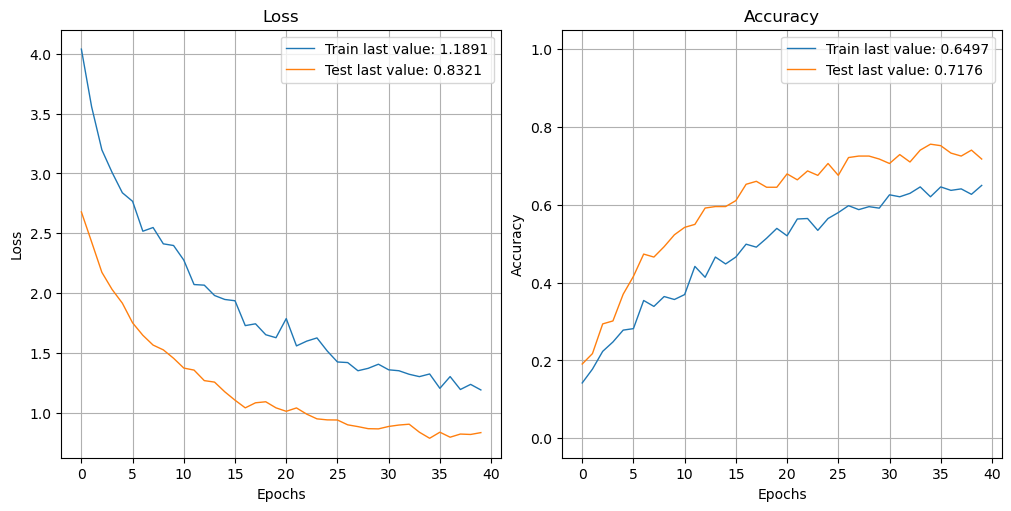

In [49]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [50]:
#batch_size = 32
path='Data/train/'
path_test='Data/test/'

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [51]:
dataset_train = dataset_fct(path, validation_split=0.2, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.2, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 945 files belonging to 7 classes.
Using 756 files for training.
Found 945 files belonging to 7 classes.
Using 189 files for validation.
Found 105 files belonging to 7 classes.


In [52]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [53]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [54]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=140, callbacks=callbacks_list, verbose=1)


Epoch 1/140


2023-05-30 12:05:07.598562: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [756]
	 [[{{node Placeholder/_4}}]]
2023-05-30 12:05:07.598740: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [756]
	 [[{{node Placeholder/_0}}]]


24/24 [==============================] - ETA: 0s - loss: 4.8325 - accuracy: 0.2434

2023-05-30 12:06:15.604925: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [189]
	 [[{{node Placeholder/_0}}]]
2023-05-30 12:06:15.605060: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [189]
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.41875, saving model to ./model3_best_weights.h5
24/24 [==============================] - 85s 4s/step - loss: 4.8325 - accuracy: 0.2434 - val_loss: 2.4188 - val_accuracy: 0.4021
Epoch 2/140
24/24 [==============================] - ETA: 0s - loss: 3.7192 - accuracy: 0.3108
Epoch 2: val_loss improved from 2.41875 to 1.85469, saving model to ./model3_best_weights.h5
24/24 [==============================] - 85s 4s/step - loss: 3.7192 - accuracy: 0.3108 - val_loss: 1.8547 - val_accuracy: 0.5344
Epoch 3/140
24/24 [==============================] - ETA: 0s - loss: 3.1408 - accuracy: 0.4048
Epoch 3: val_loss improved from 1.85469 to 1.53140, saving model to ./model3_best_weights.h5
24/24 [==============================] - 85s 4s/step - loss: 3.1408 - accuracy: 0.4048 - val_loss: 1.5314 - val_accuracy: 0.5820
Epoch 4/140
24/24 [==============================] - ETA: 0s - loss: 2.7839 - accuracy: 0.4233
Epoch 4: val_loss improved from 1.53140 to 1.36124, 

24/24 [==============================] - ETA: 0s - loss: 1.0008 - accuracy: 0.7632
Epoch 27: val_loss improved from 0.75942 to 0.75359, saving model to ./model3_best_weights.h5
24/24 [==============================] - 86s 4s/step - loss: 1.0008 - accuracy: 0.7632 - val_loss: 0.7536 - val_accuracy: 0.8307
Epoch 28/140
24/24 [==============================] - ETA: 0s - loss: 1.0539 - accuracy: 0.7619
Epoch 28: val_loss improved from 0.75359 to 0.75187, saving model to ./model3_best_weights.h5
24/24 [==============================] - 86s 4s/step - loss: 1.0539 - accuracy: 0.7619 - val_loss: 0.7519 - val_accuracy: 0.8307
Epoch 29/140
24/24 [==============================] - ETA: 0s - loss: 0.9948 - accuracy: 0.7513
Epoch 29: val_loss improved from 0.75187 to 0.75178, saving model to ./model3_best_weights.h5
24/24 [==============================] - 86s 4s/step - loss: 0.9948 - accuracy: 0.7513 - val_loss: 0.7518 - val_accuracy: 0.8466
Epoch 30/140
24/24 [==============================] - ET

In [55]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

24/24 [==============================] - 68s 3s/step - loss: 0.2650 - accuracy: 0.9114
Training Accuracy   : 0.9114

6/6 [==============================] - 17s 3s/step - loss: 0.7363 - accuracy: 0.8466
Validation Accuracy :  0.8466


In [56]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8307


2023-05-30 13:11:29.248434: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [105]
	 [[{{node Placeholder/_0}}]]
2023-05-30 13:11:29.248574: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [105]
	 [[{{node Placeholder/_0}}]]


Test Accuracy       :  0.6000


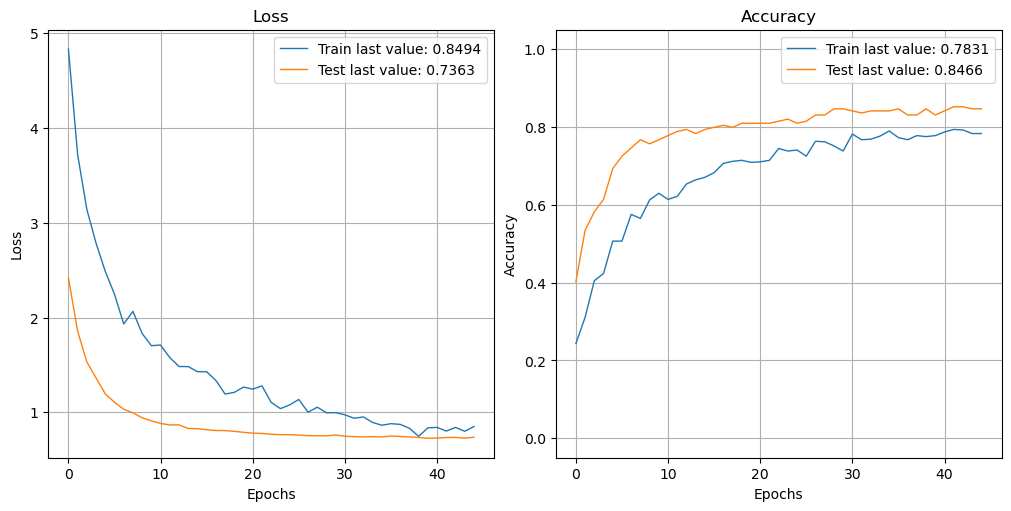

In [57]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [58]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [59]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 945 files belonging to 7 classes.
Using 709 files for training.
Found 945 files belonging to 7 classes.
Using 236 files for validation.
Found 105 files belonging to 7 classes.


In [60]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



In [61]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [62]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [63]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [64]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=140, callbacks=callbacks_list, verbose=1)


Epoch 1/140


2023-05-30 13:11:39.989618: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [709]
	 [[{{node Placeholder/_4}}]]
2023-05-30 13:11:39.989785: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [709]
	 [[{{node Placeholder/_0}}]]


23/23 [==============================] - ETA: 0s - loss: 1.8849 - accuracy: 0.2849

2023-05-30 13:12:44.973515: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [236]
	 [[{{node Placeholder/_4}}]]
2023-05-30 13:12:44.973646: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [236]
	 [[{{node Placeholder/_4}}]]



Epoch 1: val_loss improved from inf to 1.36313, saving model to ./model4_best_weights.h5
23/23 [==============================] - 87s 4s/step - loss: 1.8849 - accuracy: 0.2849 - val_loss: 1.3631 - val_accuracy: 0.6864
Epoch 2/140
23/23 [==============================] - ETA: 0s - loss: 1.4023 - accuracy: 0.5219
Epoch 2: val_loss improved from 1.36313 to 1.00105, saving model to ./model4_best_weights.h5
23/23 [==============================] - 87s 4s/step - loss: 1.4023 - accuracy: 0.5219 - val_loss: 1.0011 - val_accuracy: 0.8136
Epoch 3/140
23/23 [==============================] - ETA: 0s - loss: 1.1472 - accuracy: 0.6319
Epoch 3: val_loss improved from 1.00105 to 0.83577, saving model to ./model4_best_weights.h5
23/23 [==============================] - 87s 4s/step - loss: 1.1472 - accuracy: 0.6319 - val_loss: 0.8358 - val_accuracy: 0.7627
Epoch 4/140
23/23 [==============================] - ETA: 0s - loss: 1.0240 - accuracy: 0.6827
Epoch 4: val_loss improved from 0.83577 to 0.72681, 

Epoch 28: early stopping


In [65]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

23/23 [==============================] - 69s 3s/step - loss: 0.3041 - accuracy: 0.8928
Training Accuracy   : 0.8928

8/8 [==============================] - 22s 3s/step - loss: 0.4673 - accuracy: 0.8517
Validation Accuracy :  0.8517


In [66]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8602


2023-05-30 13:55:13.328033: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [105]
	 [[{{node Placeholder/_0}}]]
2023-05-30 13:55:13.328218: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [105]
	 [[{{node Placeholder/_4}}]]


Test Accuracy       :  0.6000


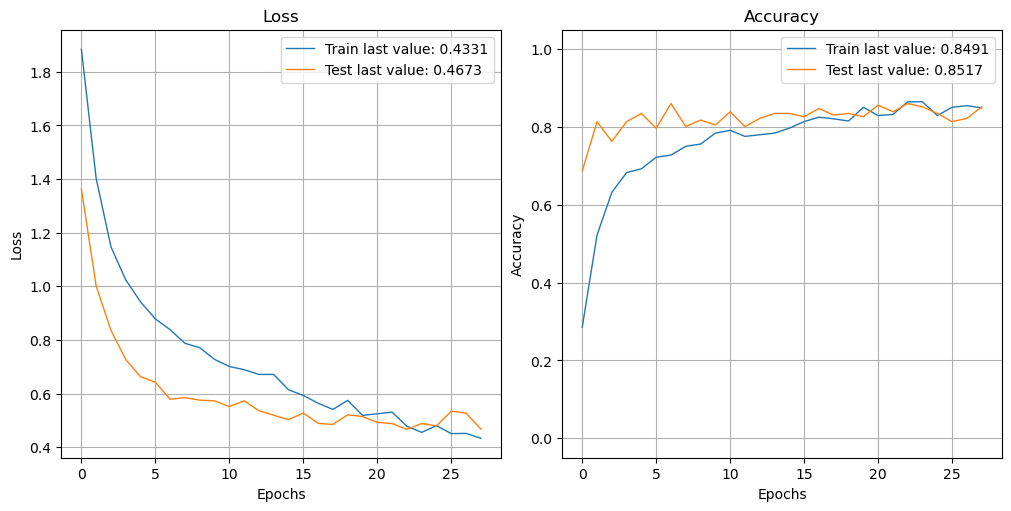

In [67]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()